In [9]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("data/RSCCASN.csv", 
                 parse_dates=True, 
                 index_col="DATE")

In [3]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [4]:
df.columns = ["Sales"]

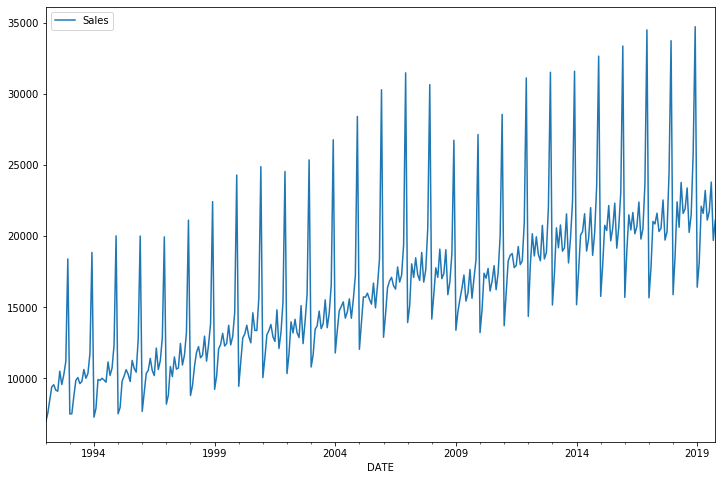

In [8]:
df.plot(figsize=(12,8));

In [10]:
len(df)

334

In [11]:
len(df) - 18 

316

In [12]:
test_size = 18
test_ind = len(df) - test_size 

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
train.shape

(316, 1)

In [15]:
test.shape

(18, 1)

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [19]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [21]:
length = 12 # length of the batches
generator = TimeseriesGenerator(scaled_train, scaled_train,
                                length=length, batch_size=1) 

In [22]:
X,y= generator[0]

In [23]:
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [24]:
y

array([[0.02047633]])

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [27]:
n_features = 1

In [28]:
model = Sequential()

model.add(LSTM(100, activation="relu", input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer="adam",
             loss="mse")

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [30]:
from tensorflow.keras.callbacks import EarlyStopping

In [31]:
early_stop = EarlyStopping(monitor="val_loss",
                          patience=2)

In [32]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length,
                                          batch_size=1)

In [33]:
model.fit_generator(generator, epochs=20,
                   validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 7s 24ms/step - loss: 0.0268 - val_loss: 0.0059
Epoch 2/20
304/304 [==============================] - 8s 25ms/step - loss: 0.0178 - val_loss: 0.0025
Epoch 3/20
304/304 [==============================] - 6s 21ms/step - loss: 0.0136 - val_loss: 0.0011
Epoch 4/20
304/304 [==============================] - 6s 21ms/step - loss: 0.0041 - val_loss: 0.0026
Epoch 5/20
304/304 [==============================] - 7s 24ms/step - loss: 0.0037 - val_loss: 0.0012


In [34]:
losses = pd.DataFrame(model.history.history)

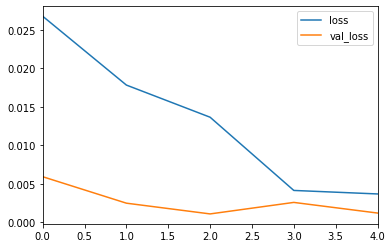

In [35]:
losses.plot()

In [36]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [38]:
true_preds = scaler.inverse_transform(test_predictions)

In [39]:
test["Predictions"] = true_preds

C:\Users\Luis\anaconda3\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [40]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21847.371798
2018-06-01,21589,20810.005580
2018-07-01,21919,21065.440589
2018-08-01,23381,22846.199568
2018-09-01,20260,20466.023587
2018-10-01,21473,21043.250692
2018-11-01,25831,25163.577777
2018-12-01,34706,36660.582994
2019-01-01,16410,17160.992181


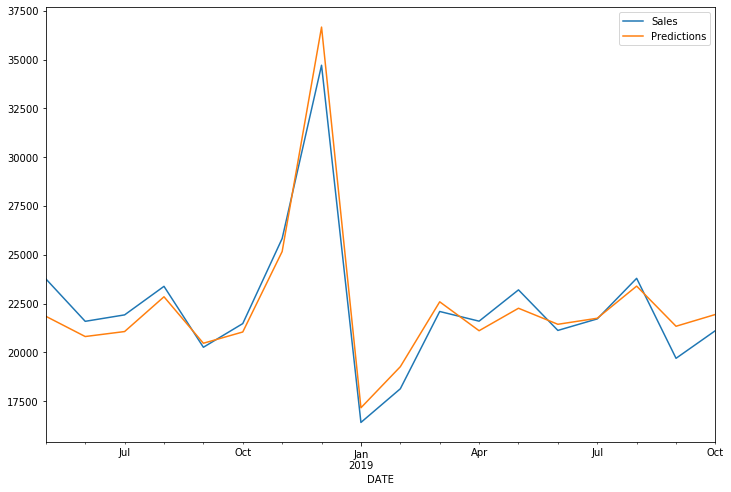

In [42]:
test.plot(figsize=(12,8));

### Forecasting

In [43]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [45]:
length = 12
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data,
                               length=length, batch_size=1)

In [46]:
model = Sequential()

model.add(LSTM(100, activation="relu", input_shape=(length, n_features)))

model.add(Dense(1))

model.compile(optimizer="adam",
             loss="mse")

In [47]:
model.fit_generator(generator, epochs=5)

Epoch 1/5
322/322 [==============================] - 9s 27ms/step - loss: 0.0299
Epoch 2/5
322/322 [==============================] - 9s 28ms/step - loss: 0.0170
Epoch 3/5
322/322 [==============================] - 8s 26ms/step - loss: 0.0093
Epoch 4/5
322/322 [==============================] - 8s 26ms/step - loss: 0.0042
Epoch 5/5
322/322 [==============================] - 8s 25ms/step - loss: 0.0024


In [49]:
forecast = []

periods = 12

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range((periods)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [50]:
forecast

[array([0.5416424], dtype=float32),
 array([0.4984457], dtype=float32),
 array([0.5075739], dtype=float32),
 array([0.57610416], dtype=float32),
 array([0.48618484], dtype=float32),
 array([0.5055474], dtype=float32),
 array([0.67237765], dtype=float32),
 array([1.0998136], dtype=float32),
 array([0.37000528], dtype=float32),
 array([0.44964665], dtype=float32),
 array([0.57243955], dtype=float32),
 array([0.51327467], dtype=float32)]

In [51]:
forecast = scaler.inverse_transform(forecast)

In [53]:
forecast_index = pd.date_range(start="2019-11-01",
                              periods=periods,
                              freq="MS")

In [54]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [55]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                          columns=["Forecast"])

In [56]:
forecast_df

,Forecast
2019-11-01,21856.999022
2019-12-01,20667.188076
2020-01-01,20918.615573
2020-02-01,22806.213097
2020-03-01,20329.475107
2020-04-01,20862.797704
2020-05-01,25457.969881
2020-06-01,37231.265262
2020-07-01,17129.425426
2020-08-01,19323.067376


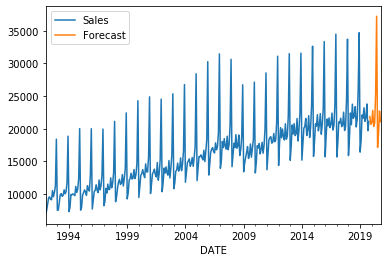

In [57]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 609)

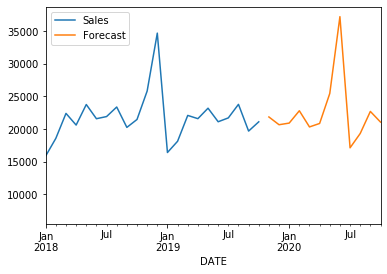

In [58]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim("2018-01-01", "2020-10-01")